<a href="https://colab.research.google.com/github/shiling2007/Python-/blob/main/survival_model_likelihood_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://nbviewer.org/gist/AustinRochford/92b06d174a7f84fded6e

from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# files.download('/content/drive/MyDrive/Colab Notebooks/Lease Payment Formula.ipynb') 
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 999)
pd.set_option("max_colwidth", 500)
# try:
#  device_name = os.environ['COLAB_TPU_ADDR']
#  TPU_ADDRESS = 'grpc://' + device_name
#  print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#  print('TPU not found')
%load_ext autoreload
%autoreload 2

In [3]:
# !pip install lifelines

In [4]:
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels import api
from scipy.optimize import minimize
from scipy.stats import norm, uniform
from statsmodels.formula.api import probit
from lifelines import (KaplanMeierFitter, WeibullFitter,  NelsonAalenFitter, PiecewiseExponentialFitter, LogLogisticFitter, LogNormalFitter, CoxPHFitter, ExponentialFitter)
from scipy.stats import weibull_min, expon, randint , lognorm, norm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#survival data generation

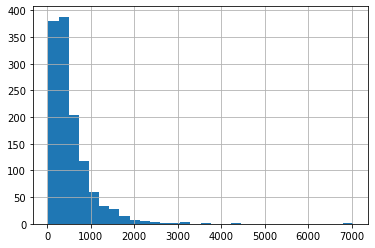

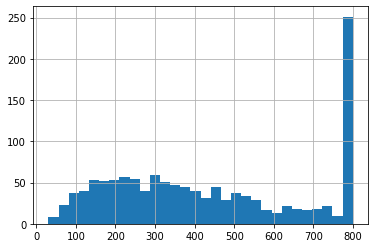

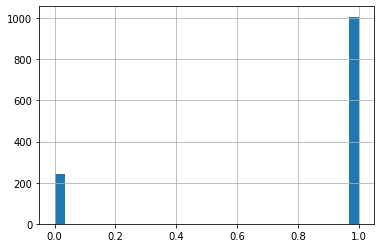

In [6]:
n_obs=1250
censored=800
loc=6.0; scale=0.8;

days=np.exp(norm.rvs(loc=loc, scale=scale, size=n_obs, random_state=123))
days_censored=np.minimum(days, censored)
event=np.where(days_censored==censored, 0,1)

data=pd.DataFrame(np.c_[days,days_censored,event], columns=['days','days_censored','event'])
data.days.hist(bins=30)
plt.show()
data.days_censored.hist(bins=30)
plt.show()
data.event.hist(bins=30)


<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 1250 total observations, 243 right-censored observations>


<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 1250 total observations, 243 right-censored observations>
   number of observations = 1250
number of events observed = 1007
           log-likelihood = -7204.240
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%       z       p   -log2(p)
mu_     5.981      0.023            5.936            6.027 255.821 <0.0005        inf
sigma_  0.803      0.019            0.767            0.840 -10.471 <0.0005     82.812
---
AIC = 14412.481

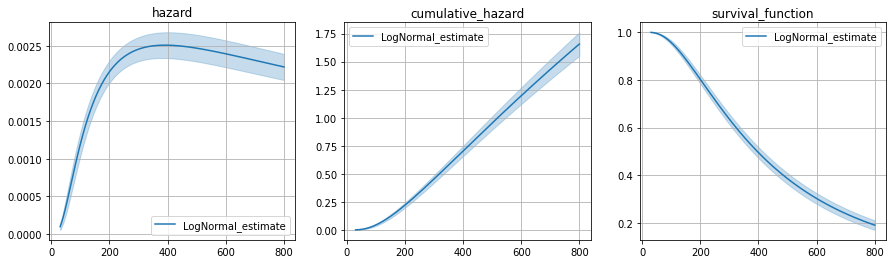

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
lnf = LogNormalFitter().fit(data["days_censored"], data["event"])
print(lnf)
lnf.plot_hazard(ax=ax[0], grid=True)
lnf.plot_cumulative_hazard(ax=ax[1], grid=True)
lnf.plot_survival_function(ax=ax[2], grid=True)
ax[0].set_title("hazard"); ax[1].set_title("cumulative_hazard"); ax[2].set_title("survival_function")

lnf.print_summary(3)

In [8]:
data

,days,days_censored,event
0,169.270075,169.270075,1.0
1,895.942608,800.000000,0.0
2,505.922147,505.922147,1.0
3,120.900057,120.900057,1.0
4,253.945531,253.945531,1.0
...,...,...,...
1245,170.184385,170.184385,1.0
1246,191.876095,191.876095,1.0
1247,224.957459,224.957459,1.0
1248,256.997036,256.997036,1.0


In [9]:
#lognormal survival distribution
def _ll_survival(y, beta, censored):
    mu=beta[0]
    sigma=beta[1]
    # X=np.where(y==censored, 0, 1)
    Y=np.log(y)
    pdf=norm.pdf(Y,  loc=mu, scale=sigma)
    cdf=norm.cdf(Y,  loc=mu, scale=sigma)   
    prob=(y<censored)*pdf + (y>=censored)*(1-cdf)
    ll=np.log(prob)
    return ll.sum() 

class MySurvical_mle(GenericLikelihoodModel):
    def __init__(self, endog, exog=None,  **kwds):
      super(MySurvical_mle, self).__init__(endog, exog,  **kwds)

    def nloglikeobs(self, params):
	    beta = params
	    ll = _ll_survival(self.endog, beta, censored)
	    return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
    # we have one additional parameter and we need to add it for summary
      # self.exog_names.append('mu') ;self.exog_names.append('sigma');
      if start_params == None:
        # start_params =np.array([0.5,2,0,1,4,2])
        start_params =np.array([1,1])
        return super(MySurvical_mle, self).fit(start_params=start_params, maxiter=maxiter, maxfun=maxfun,  **kwds)

y=data.days_censored
X=data.event
model_survival=MySurvical_mle(y).fit()
print(model_survival.summary())
print(model_survival.params)

Optimization terminated successfully.
         Current function value: 1.167510
         Iterations: 56
         Function evaluations: 108
                            MySurvical_mle Results                            
Dep. Variable:          days_censored   Log-Likelihood:                -1459.4
Model:                 MySurvical_mle   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Tue, 21 Dec 2021                                         
Time:                        22:09:20                                         
No. Observations:                1250                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [10]:
def _ll_survival(y, beta, censored):
    mu=beta[0]
    sigma=beta[1]
    # X=np.where(y==censored, 0, 1)
    Y=np.log(y)
    pdf=norm.pdf(Y,  loc=mu, scale=sigma)
    cdf=norm.cdf(Y,  loc=mu, scale=sigma)   
    prob=(y<censored)*pdf + (y>=censored)*(1-cdf)
    ll=np.log(prob)
    return ll.sum() 
y=data.days_censored
X=data.event
beta= model_survival.params

ll= _ll_survival(y,  beta, censored)


print(ll)

-1459.3868817443938


In [11]:
#lognormal survival distribution
def _ll_survival(y, beta,censored):
    mu=beta[0]
    sigma=beta[1]
    # X=np.where(y==censored, 0, 1)
    # Y=np.log(y)
    pdf=lognorm.pdf(y ,sigma, loc=0, scale=np.exp(mu))
    cdf=lognorm.cdf(y, sigma, loc=0, scale=np.exp(mu))   
    prob=(y<censored)*pdf + (y>=censored)*(1-cdf)
    ll=np.log(prob)
    return ll.sum() 

class MySurvical_mle(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
      super(MySurvical_mle, self).__init__(endog, exog,  **kwds)

    def nloglikeobs(self, params):
	    beta = params
	    ll = _ll_survival(self.endog, beta,censored)
	    return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
    # we have one additional parameter and we need to add it for summary
      # self.exog_names.append('mu') ;self.exog_names.append('sigma');
      if start_params == None:
        # start_params =np.array([0.5,2,0,1,4,2])
        start_params =np.array([1,1])
        return super(MySurvical_mle, self).fit(start_params=start_params, maxiter=maxiter, maxfun=maxfun,  **kwds)

y=data.days_censored
X=data.event
model_survival=MySurvical_mle(y).fit()
print(model_survival.summary())
print(model_survival.params)

Optimization terminated successfully.
         Current function value: 5.763392
         Iterations: 56
         Function evaluations: 108
                            MySurvical_mle Results                            
Dep. Variable:          days_censored   Log-Likelihood:                -7204.2
Model:                 MySurvical_mle   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Tue, 21 Dec 2021                                         
Time:                        22:10:05                                         
No. Observations:                1250                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------